In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

file_path = 'data_daily.csv'
data = pd.read_csv(file_path)

data['Date'] = data['# Date']
data.drop('# Date', axis=1, inplace=True)
data.to_csv('data_daily.csv', index=False)

data = pd.read_csv(file_path)
data.head()


,Receipt_Count,Date
0,7564766,2021-01-01
1,7455524,2021-01-02
2,7095414,2021-01-03
3,7666163,2021-01-04
4,7771289,2021-01-05


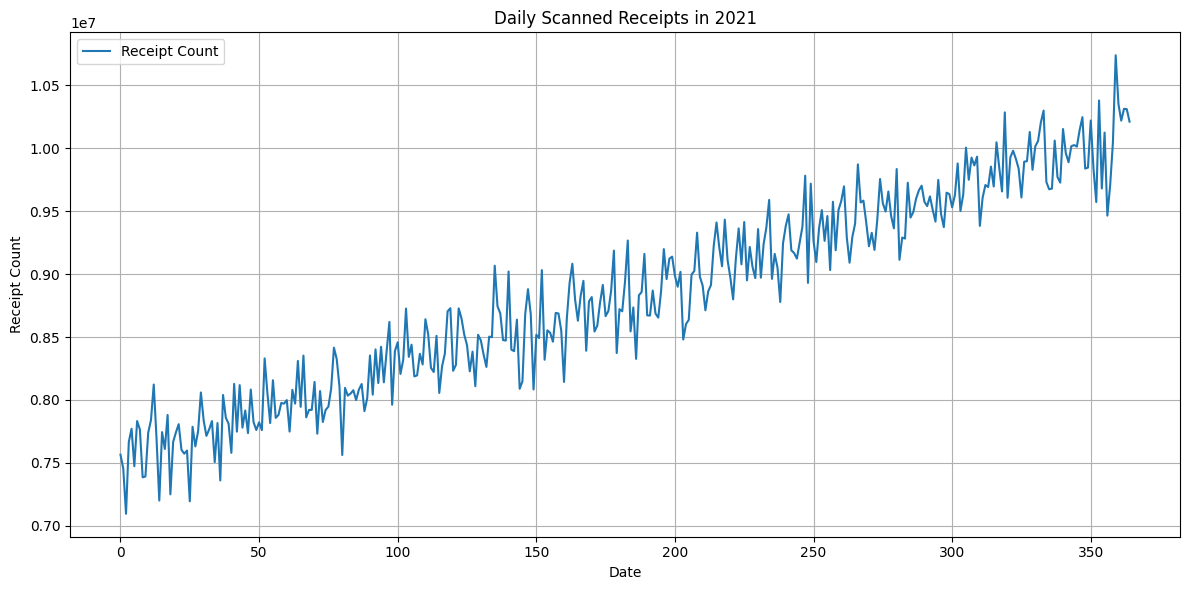

In [2]:
# Visualize the time series data
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Receipt_Count'], label='Receipt Count')
plt.title('Daily Scanned Receipts in 2021')
plt.xlabel('Date')
plt.ylabel('Receipt Count')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


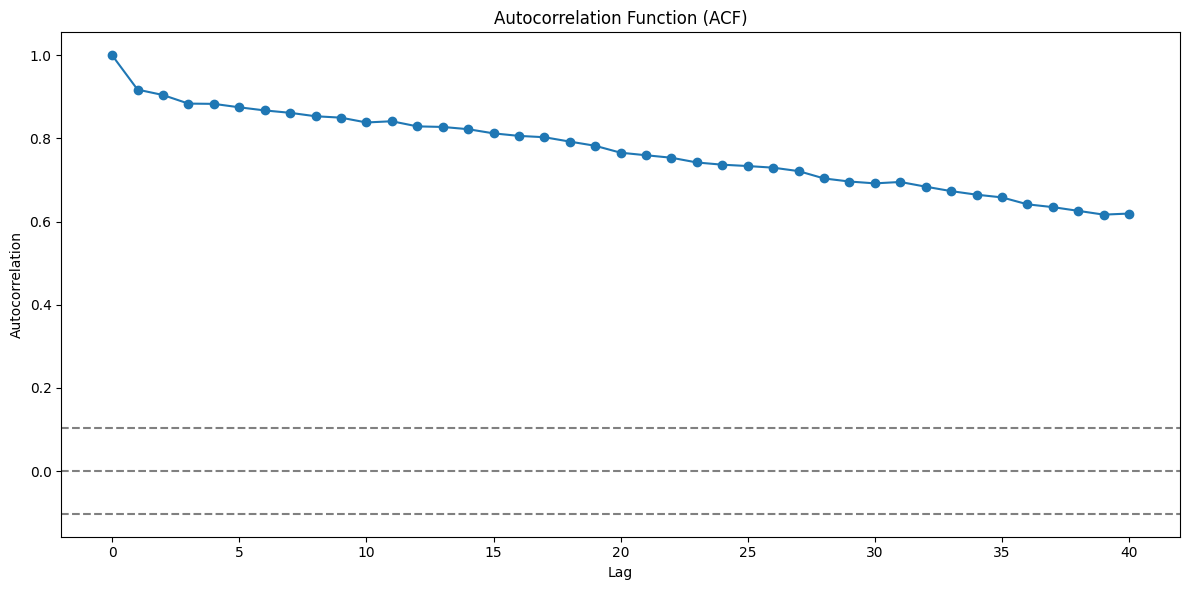

1

In [3]:
from statsmodels.tsa.stattools import acf

# Calculate the autocorrelation
lag_acf = acf(data['Receipt_Count'], nlags=40, fft=False)

# Plot ACF
plt.figure(figsize=(12, 6))
plt.plot(lag_acf, marker='o')
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(
    y=-1.96/np.sqrt(len(data['Receipt_Count'])), linestyle='--', color='gray')
plt.axhline(
    y=1.96/np.sqrt(len(data['Receipt_Count'])), linestyle='--', color='gray')
plt.title('Autocorrelation Function (ACF)')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.tight_layout()
plt.show()

# Get the lag at which the ACF is maximum (excluding lag 0)
seasonality_lag = np.argmax(lag_acf[1:]) + 1
seasonality_lag


In [4]:
def exponential_smoothing_forecast(series, alpha, beta):
    """
    Function to forecast time series data using Exponential Smoothing model.
    :param series: Time series data
    :param alpha: Smoothing parameter for level
    :param beta: Smoothing parameter for trend
    :return: Forecasted series
    """
    # Initialize level and trend
    level = series[0]
    trend = series[1] - series[0]

    # Initialize forecasted series
    forecasted_series = [level + trend]

    # Update level and trend and forecast the series
    for t in range(1, len(series)):
        last_level, level = level, alpha * \
            series[t] + (1 - alpha) * (level + trend)
        trend = beta * (level - last_level) + (1 - beta) * trend
        forecasted_series.append(level + trend)

    return forecasted_series


def optimize_parameters(series):
    """
    Function to find the optimal alpha and beta by minimizing the MSE.
    :param series: Time series data
    :return: Optimal alpha and beta
    """
    # Initialize optimal parameters and minimum mse
    optimal_alpha = optimal_beta = 0
    min_mse = float('inf')

    # Grid search to find optimal parameters
    for alpha in np.arange(0.01, 1, 0.01):
        for beta in np.arange(0.01, 1, 0.01):
            forecasted_series = exponential_smoothing_forecast(
                series, alpha, beta)
            mse = np.mean((series[1:] - forecasted_series[:-1]) ** 2)
            if mse < min_mse:
                min_mse = mse
                optimal_alpha = alpha
                optimal_beta = beta

    return optimal_alpha, optimal_beta


# Find optimal parameters
optimal_alpha, optimal_beta = optimize_parameters(data['Receipt_Count'].values)

# Forecast the series with optimal parameters
forecasted_series = exponential_smoothing_forecast(
    data['Receipt_Count'].values, optimal_alpha, optimal_beta)

# Create a DataFrame with actual and forecasted values
forecasted_df = pd.DataFrame({
    'Actual': data['Receipt_Count'].values[1:],
    'Forecasted': forecasted_series[:-1]
}, index=data.index[1:])

# Return optimal parameters and first few rows of forecasted DataFrame
optimal_alpha, optimal_beta, forecasted_df.head()


(0.19,
 0.13,
     Actual    Forecasted
 1  7455524  7.455524e+06
 2  7095414  7.346282e+06
 3  7666163  7.183179e+06
 4  7771289  7.171437e+06
 5  7473320  7.196716e+06)

In [5]:
from pandas.tseries.offsets import MonthEnd

# Initialize the last level and trend from the 2021 data
level = data['Receipt_Count'].values[-1]
trend = forecasted_series[-1] - forecasted_series[-2]

# Initialize the start date as the last date in the 2021 data
start_date = data.index[-1]

# Initialize the forecasted DataFrame for 2022
forecasted_2022 = pd.DataFrame(columns=['Forecasted'], index=pd.date_range(
    start=start_date, periods=13, freq='M')[1:])

# Forecast the daily receipts for each month in 2022 and calculate the monthly total
for month_end in forecasted_2022.index:
    daily_forecasted = []
    while start_date < month_end:
        start_date += pd.Timedelta(days=1)
        level = optimal_alpha * level + (1 - optimal_alpha) * (level + trend)
        trend = optimal_beta * (level - level) + (1 - optimal_beta) * trend
        daily_forecasted.append(level + trend)
    forecasted_2022.loc[month_end, 'Forecasted'] = np.sum(daily_forecasted)

# Display the forecasted monthly total receipts for 2022
forecasted_2022

TypeError: '<' not supported between instances of 'int' and 'Timestamp'

In [3]:
data = pd.read_csv('data_daily.csv')



# Check if 'Date' column is in the DataFrame
if 'Date' not in data.columns:
    pass
else:
    data['Date'] = pd.to_datetime(data['# Date'])
    data.set_index('Date', inplace=True)
